## Exercise 8 :  Time Series Analysis and Perceptron

**Total points (10 Points)**

**Main topics**: 
- Time series analysis: stationary time series analysis, forecasting time series with ARIMA.
- Perceptron: build Perceptron for binary classification problem.


The deadline to submit your solutions to this exercise is **Tuesday 23.04.2024 by the end of the day (23:59 CET)**. 

Please submit your solutions in python notebook format and rename the file as "**Exercise_08_FirstName_LastName.ipynb**"

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm  

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Part 1: Time Series Analysis (5 points)

### 1.1 Stationary Time Series
Time series (TS) is a collection of data points collected at different recording (time) intervals<br>
These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis

How is forecast different than a regression problem?
* It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold
* Along with an increasing or decreasing trend, most TS have some form of seasonality trends

In [2]:
ts = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month')
ts.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'Number of Air Passengers')

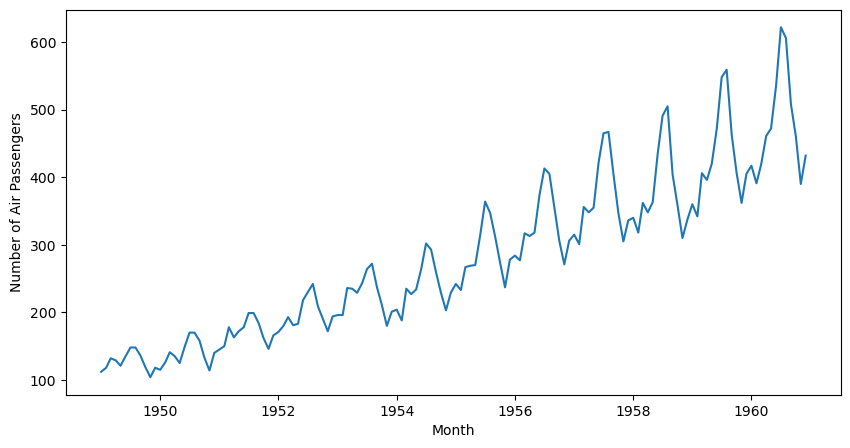

In [3]:
plt.figure(figsize=(10,5))
plt.plot(ts)
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")

* As we know, a stationary time series is one for which characteristics like mean and variance does not change over time
* Preparing the data for analyzing the Rolling Mean and Standard Deviation to check stationarity for given Time Series

In [4]:
rolmean=ts.rolling(window=12).mean()
rolstd=ts.rolling(window=12).std()
# print(rolmean.head(15))
# print(rolstd.head(15))

Plotting the Rolling Mean and Standard Deviation, which has window of 12, we conclude that it is non-stationary because mean and variance are not constant

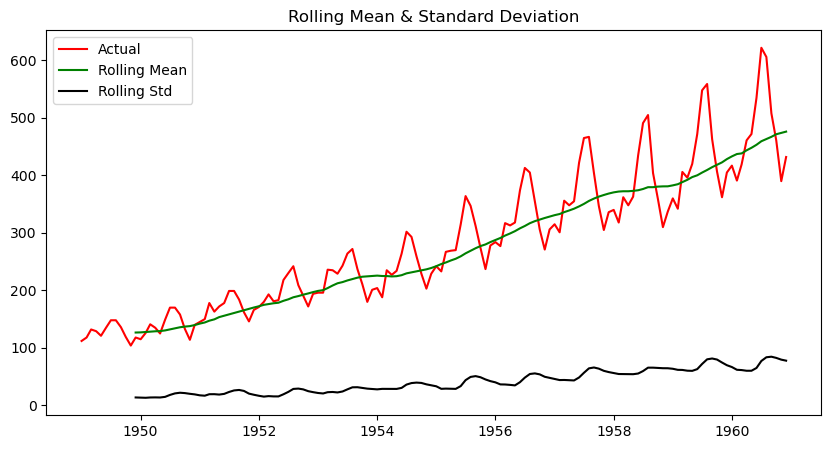

In [5]:
plt.figure(figsize=(10,5))
actual=plt.plot(ts, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

* Another way of checking for stationarity of the time seris is using Augmented Dickey-Fuller (ADF) Test to check stationarity.
* ADF has as Null hypothesis that the Time Series is non-stationary

In [6]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(ts, autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


* From above ADF test, we fail to reject the null hypothesis, since p-value is greater than 0.05. Hence, we cannot rule out non-stationarity of the time series.

To remove the non-stationarity of the time series, we can apply first a log transform as shown below and then plot the rolling average and standard deviation.

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

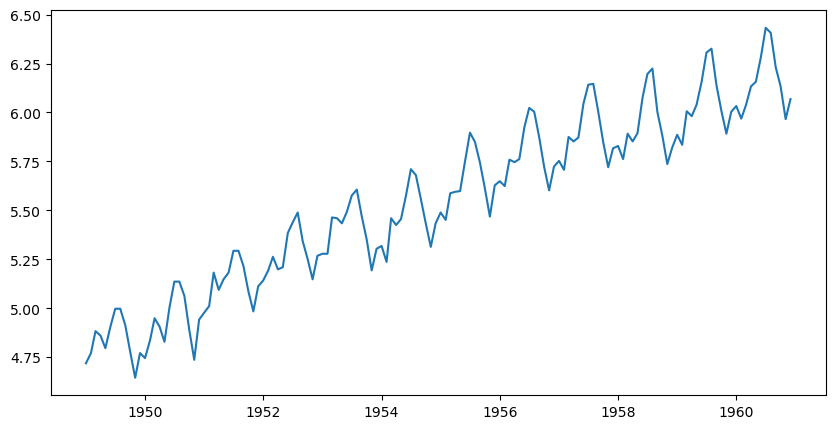

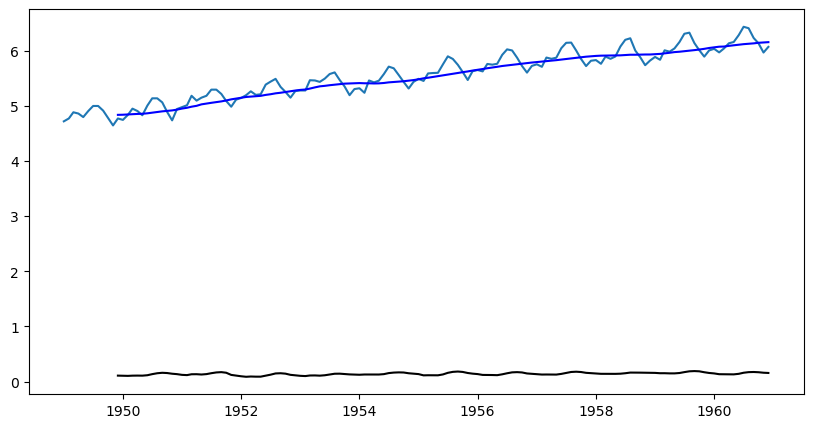

In [7]:
plt.figure(figsize=(10,5))
ts_log=np.log(ts)
plt.plot(ts_log)
plt.figure(figsize=(10,5))
MAvg=ts_log.rolling(window=12).mean()
MStd=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(MStd, color='black')
plt.plot(MAvg, color='blue')
plt.legend

**Task 1.1 ( 1 point)** Decompose time series into its components (Trend, Seasonality and Residual). Check stationarity of the decomposed components.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose


We can also try to remove the non-stationarity from the log transform of the time series using differencing method.

In [9]:
ts_log_diff=ts_log-MAvg
ts_log_diff=ts_log_diff.dropna()
ts_log_diff.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


**Task 1.2. (2 points)** Create the function that plots the input time series, rolling average and standard deviations over 12 months to check for the stationarity, and performs ADF test.
Apply the function on the output of the differencing method. Justify the results.


These results are good but it is clear that our time series is still affected by seasonality. To try to remove it we can subtract the shifted values. We should choose a period of 12 for the shift since 12 are the months of the years that gives periodicity to our data.

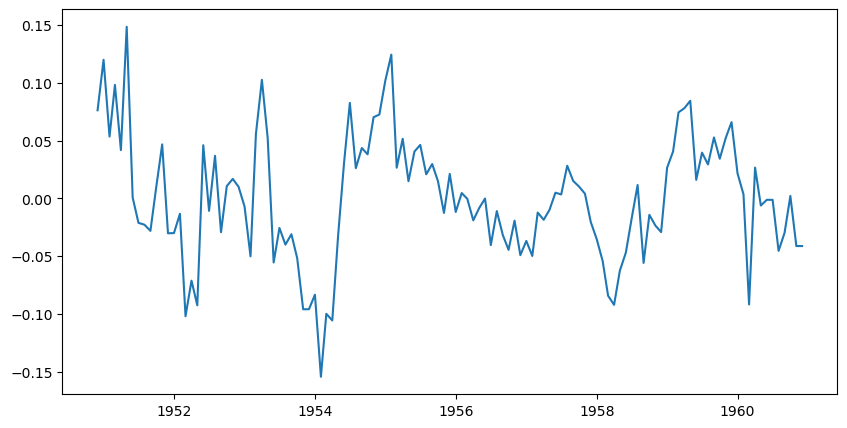

In [10]:
# shifting the data to generate lagged data
plt.figure(figsize=(10,5))
ts_shift=ts_log_diff-ts_log_diff.shift(periods=12)
ts_shift=ts_shift.dropna()
plt.plot(ts_shift)


## 1.2: Forecasting a Time Series with ARIMA 

Let's make a model of the TS after differencing. It is relatively easier to add noise and seasonality back into predicted residuals in this case. 

Having performed the trend and seasonality estimation techniques, there can be two situations:

- A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.

- A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.




For this exercise we use a time series that is already stationary.

In [11]:
data = pd.read_csv('data/data_pbe.txt', usecols=[0], skiprows=1, sep=" ", header=None)
data.columns = ["Energy"]
data.head()

,Energy
0,-129.583931
1,-129.618996
2,-129.603909
3,-129.932441
4,-129.952756


**Task 1.2 (2 points)** Create an AR, an MA model and fit them to the transformed (shifted) time series, use the proper parameter. Plot the transformed time series with the fitted values of the each model. Compare the results and estimate *through model analysis* what is the best. 

In [12]:
# AR model


In [13]:
# Plot residual errors


In [14]:
# MA model


In [15]:
# Plot residual errors


### Part 2: Perceptron (5 points)
Build a perceptron to classify points by drawing a decision boundary in a plane. Let's begin by generating some data points for our perceptron.

**Task 2.1 (1 point)** Create 2 cluster of points (150 points) in a 2D space, be sure that the clusters are are separated such that our simple perceptron can classify them easiy (standard deviation: 1.05), and plot them. \
(Hint: sklearn.dataset.make_blobs, the parameter I suggested are not mandatory, you can play with them). 

For our single perceptron aimed at binary classification, we require the output to be either 0 or 1. To achieve this, we employ a step function.
\
\
**Task 2.2 (0.5 point)** Define a step function, which takes a number x as input. If x is greater than 0, it returns 1; otherwise, it returns 0.

**Task 2.3 (2.5 points)** Define the perceptron function. 
\
\
The function should have the following input: the data, the labels, the learning rate and the number of iterations. \
The function's outputs should include the parameter array and a list to keep track of the number of misclassified points at each iteration.

*Some hints:* 
- Start by defining variables for the number of training examples and the number of features.
- Initialize the parameter array with zeros, add one to its dimension for the bias term.
- Create an empty list to store the number of misclassifications for each iteration.
- Iterate over the number of iteration and loop through each example point.
- insert a 1 in position 0 for every point for the bias term, i.e., x[0]=1.
- Calculate the prediction.
- Keep track of the misclassification: update if the example is misclassified.

**Task 2.4 (1 point)** Evaluate the perceptron function on our data and use the following function to plot the decision boundary. 

In [16]:
def plot_decision_boundary(X, theta):
    
    # X --> Inputs
    # theta --> parameters
    
    # The Line is y=mx+c
    # So, Equate mx+c = theta0.X0 + theta1.X1 + theta2.X2
    # Solving we find m and c
    x1 = [min(X[:,0]), max(X[:,0])]
    m = -theta[1]/theta[2]
    c = -theta[0]/theta[2]
    x2 = m*x1 + c
    
    # Plotting
    fig = plt.figure(figsize=(10,8))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "r^")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.title('Perceptron Algorithm')    
    plt.plot(x1, x2, 'y-')